In [23]:
import os
import re
import sys
import string
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter


import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub


from pathlib import Path
from transformers import BertTokenizerFast, TFBertModel
from sklearn.model_selection import train_test_split as tts


In [3]:
text_dir = "../data/raw/text"
labels_dir =  "../data/raw/labels"
audio_dir = "../data/raw/audio"



## Nettoyage, traitement etc
Surtout utilisé pour prétraitement, mais une partie utile pour inférence de nouvelles données

In [4]:
text_files = glob.glob(f"{text_dir}/*.txt")

## Chaque ligne de texte est précédée d'un "stamp" qui indique le clip de l'enregistrement etc
def remove_stamps_str(line)->str:
    #clip_num = re.search('.+___\d\d?\d?___.+', line).group(0)
    stamp = re.search('.+___', line).group(0)
    new_line = line.strip(stamp)
    return new_line

## Pour python < 3.9, sinon str.removeprefix() de base
def removeprefix(self: str, prefix: str, /) -> str:
    if self.startswith(prefix):
        return self[len(prefix):]
    else:
        return self[:]


In [5]:


def text_list_generator(files_list, text_dir):
    text_list = []
    for filename in files_list:
        with open(file = filename, encoding = 'utf-8') as f:

            ##WINDOWS SPECIFIC
            if sys.platform == 'win32':
                videoid = removeprefix(filename, text_dir + '\\').rstrip('.txt')
            else :
                videoid = removeprefix(filename, text_dir + '/').rstrip('.txt')
            lines = f.readlines()
            for line_number, text_line in enumerate(lines):
                clean_line = remove_stamps_str(text_line)
                clip_id = videoid +'_'+ text_line.split('___')[1]
                #clip_id = videoid +'_' +str(line_number)
                yield (clip_id, clean_line.rstrip())


"\ncorpus = []\ntext = []\ntext_list = []\nfor filename in text_files:\n    text_str = ''\n    with open(file=filename, encoding='utf-8') as f:\n        lines = f.readlines()\n        for count, line in enumerate(lines):\n            clean_line = remove_stamps_str(line)\n            text.append(clean_line)\n    text_list.append(text)\n    "

In [63]:
#Retire tous les timestamps en début de ligne, présents dans chaque transcript
def remove_stamps_str(line)->str:
    stamp = re.search('.+___', line).group(0)
    new_line = line.strip(stamp)
    return new_line

#Retire les charactères non-ascii 
def remove_nonascii(line)->str:
    ascii_line = line.encode(encoding = 'ascii', errors = 'ignore').decode()
    return ascii_line

#met tout en minuscules, retire les nombres et stopwords
def clean_punct_digits(line)->str:
    new_line = line.translate(str.maketrans('', '', string.punctuation))
    new_line = ' '.join([word.lower() for word in new_line.split() if (len(word) >=2 and word.isalpha())])
    return new_line



### DF des labels

In [7]:
label_df = pd.read_csv("../data/interim/labels/interim.csv")
display(label_df)

,id,anger,disgust,fear,happiness,sadness,surprise,sentiment
0,--qXJuDtHPw_5,0,0,0,1,0,0,1
1,-3g5yACwYnA_10,0,0,0,0,0,0,1
2,-3g5yACwYnA_13,0,0,0,0,0,0,1
3,-3g5yACwYnA_2,0,0,0,1,0,0,0
4,-3g5yACwYnA_3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
21860,zwTrXwi54us_6,0,0,0,0,0,0,0
21861,zwTrXwi54us_7,0,0,0,0,0,0,0
21862,zwTrXwi54us_8,0,0,0,0,0,0,0
21863,zwTrXwi54us_9,0,0,0,0,0,0,1


### Données texte

À partir des fichiers .txt, génère un dataframe qui contient une entrée pour chaque ligne de texte

In [60]:
corpus = (text for text in text_list_generator(text_files))
df_text = pd.DataFrame(corpus)
df_text.columns = ['id', 'text']

In [61]:
display(df_text.head(5))

,id,text
0,--qXJuDtHPw_0,I see that there are three category of writers.
1,--qXJuDtHPw_1,"I define them as being an author, a writer, an..."
2,--qXJuDtHPw_2,"An author, I like to classify as somebody who ..."
3,--qXJuDtHPw_3,These are the well-known authors of our time a...
4,--qXJuDtHPw_4,"Then, there is the writer."


Comme le texte contient des charactères non-conformes (non ascii, autres langues etc), et de la mauvaise ponctuation,
on nettoie chaque entrée en retirant ponctuation, nombres et non-ascii.

In [66]:
df_text['text'] =  df_text.text.apply(remove_nonascii)
df_text['clean_text'] = df_text.text.apply(lambda s : clean_punct_digits(s))

display(df_text.head(3))

,id,text,clean_text
0,--qXJuDtHPw_0,I see that there are three category of writers.,see that there are three category of writers
1,--qXJuDtHPw_1,"I define them as being an author, a writer, an...",define them as being an author writer and stor...
2,--qXJuDtHPw_2,"An author, I like to classify as somebody who ...",an author like to classify as somebody who wri...


In [65]:
frame = pd.merge(df_text, label_df, on = 'id', how = 'inner')
display(frame.head(3))


,id,text,clean_text,anger,disgust,fear,happiness,sadness,surprise,sentiment
0,--qXJuDtHPw_5,I see that a writer is somebody who has an inc...,see that writer is somebody who has an incredi...,0,0,0,1,0,0,1
1,-3g5yACwYnA_2,Key Polymer brings a technical aspect to our o...,key polymer brings technical aspect to our ope...,0,0,0,1,0,0,0
2,-3g5yACwYnA_3,We're a huge user of adhesives for our operati...,were huge user of adhesives for our operation ...,0,0,0,0,0,0,0


Création d'un nouveau dataframe, "new polarity", pour n'utiliser que le texte nettoyé et la polarité du sentiment, de 0 pour négatif à 2 pour positif.

In [70]:
new_polarity_df = frame.copy()
new_polarity_df.drop(columns=['id', 'text','anger', 'disgust','fear','happiness','sadness', 'surprise'], inplace= True)
#Originalement, les valeurs sont de -1 à 1 mais modèle ne peut utiliser des valeurs négatives comme ça
new_polarity_df.sentiment = new_polarity_df.sentiment.apply(lambda x : x+1)
display(new_polarity_df.head(3))


,clean_text,sentiment
0,see that writer is somebody who has an incredi...,2
1,key polymer brings technical aspect to our ope...,1
2,were huge user of adhesives for our operation ...,1


In [21]:
display(new_polarity_df.sentiment.value_counts())



1    7487
2    4996
0    2906
Name: sentiment, dtype: int64

Les données ne sont pas très bien balancées, mais la performance est bonne quand même

In [24]:

MAX_LEN = 128


module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
BERT_LAYER = hub.KerasLayer(module_url, trainable=True)
TOKENIZER = BertTokenizerFast.from_pretrained('bert-base-uncased')




#Interesting/meaningful metrics
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall')
]



#Encodes lists of texts into BERT-useable tensors
def bert_encode(texts, tokenizer=TOKENIZER, max_len=MAX_LEN):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


#Building a neural-net that uses BERT embeddings
def build_model(bert_layer=BERT_LAYER, max_len=MAX_LEN):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    #net = tf.keras.layers.Dense(128, activation= 'relu')(clf_output)
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(3, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08), loss='categorical_crossentropy', metrics=METRICS)
    
    return model


def train_dnn(model, X_train, y_train, e=3):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint_model2.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

    train_input = bert_encode(X_train)
    train_labels = y_train

    train_history = model.fit(
            train_input, train_labels, 
            validation_split=0.2,
            epochs=e,
            callbacks=[checkpoint, earlystopping],
            batch_size=32,
            verbose=1
            )
    return train_history


    

#data = pd.read_csv('polarity_balanced.csv')
data = new_polarity_df
x = data.clean_text.values
dummy_sents = pd.get_dummies(data.sentiment)
y = dummy_sents.values
X_train, X_test, y_train, y_test = tts(x, y, test_size = 0.1)
model2 = build_model()

histo = train_dnn(model2, X_train, y_train)



Epoch 1/3
347/347 [==============================] - ETA: 0s - loss: 0.8096 - accuracy: 0.6181 - precision: 0.6586 - recall: 0.5178 
Epoch 1: val_accuracy improved from -inf to 0.69422, saving model to checkpoint_model2.h5
347/347 [==============================] - 3787s 11s/step - loss: 0.8096 - accuracy: 0.6181 - precision: 0.6586 - recall: 0.5178 - val_loss: 0.6777 - val_accuracy: 0.6942 - val_precision: 0.7195 - val_recall: 0.6325
Epoch 2/3
347/347 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.7248 - precision: 0.7423 - recall: 0.6806
Epoch 2: val_accuracy did not improve from 0.69422
347/347 [==============================] - 3691s 11s/step - loss: 0.6407 - accuracy: 0.7248 - precision: 0.7423 - recall: 0.6806 - val_loss: 0.6733 - val_accuracy: 0.6910 - val_precision: 0.7025 - val_recall: 0.6682
Epoch 3/3
347/347 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.7994 - precision: 0.8132 - recall: 0.7782
Epoch 3: val_accuracy did not 

In [27]:
loaded_model = tf.keras.models.load_model('checkpoint_model2.h5', custom_objects={'KerasLayer':hub.KerasLayer})

In [28]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

In [34]:
texts = ['I really really love this!', 'This is awful']
enc_texts = bert_encode(texts)

In [54]:
for pred in loaded_model.predict(enc_texts):
    prob = max(pred)
    print(np.argmax(pred), f"{np.round(prob, 3)} %")


1/1 [==============================] - 0s 279ms/step
2 0.9580000042915344 %
0 0.9710000157356262 %


In [55]:
import matplotlib.pyplot as plt

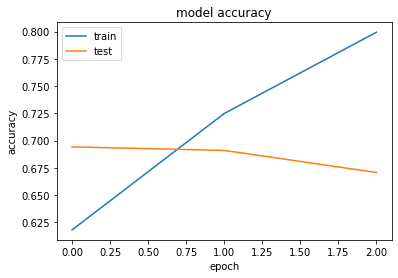

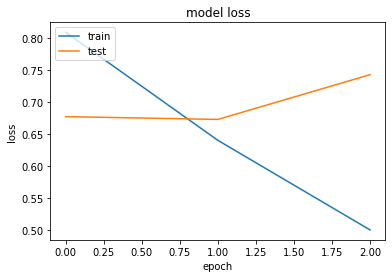

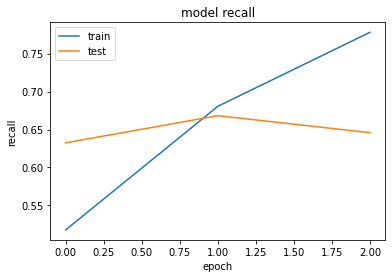

In [58]:
# summarize history for accuracy
plt.plot(histo.history['accuracy'])
plt.plot(histo.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histo.history['loss'])
plt.plot(histo.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(histo.history['recall'])
plt.plot(histo.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()